In [1]:
import findspark as fs

import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import pandas as pd

print(sys.executable)
print(sys.path)
print(sys.version)

import photutils
from photutils import detect_threshold
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D

#from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import time

import shutil
from math import pi, log, sqrt
from tqdm import tqdm
import fnmatch
import random
import warnings
warnings.filterwarnings("ignore")

/home/s2494876/miniconda3/envs/sddm/bin/python
['/home/s2494876/miniconda3/envs/sddm/lib/python36.zip', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/lib-dynload', '', '/home/s2494876/.local/lib/python3.6/site-packages', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/site-packages', '/home/s2494876/.local/lib/python3.6/site-packages/IPython/extensions', '/home/s2494876/.ipython']
3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]


In [2]:
try:
    sc = SparkContext(appName="SDDM")
    #, master='spark://fs.dslc.liacs.nl:7078')
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
    print('warn')
    
print(sc._conf.get('spark.driver.memory'))

None


In [3]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"
writeable = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/"

# Calculate radius mosaic

In [4]:
def mosaic(file):
    hdul = fits.open(file)
    # data = hdul[0].data # The intensity data
    conv = hdul[0]._header["BMAJ"] # Should be 1/4 * BMAJ
    
    x = hdul[0]._header['NAXIS1']
    y = hdul[0]._header['NAXIS2']
    print(hdul[0]._header['CDELT1'])
    center = (x/2, y/2)

    # finite_area = np.sum(np.isfinite(data))
    # radius = np.sqrt(finite_area/pi) * conv
    radius = (max(x, y) / 2) * conv * (3/8)
    
    w = WCS(hdul[0].header)
    ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)
    
    return np.array((radius, ra, dec))

In [5]:
fits_files = [mosaic_path + f for f in os.listdir(mosaic_path)]
random.shuffle(fits_files)
file_paths = sc.parallelize(fits_files, 64) # , len(fits_files)
len(file_paths.collect())

228

In [6]:
test = file_paths.map(lambda fits: (mosaic(fits)))
info = np.array(test.collect())

# Find overlapping mosaics

In [7]:
overlap_dict = {k.split('/')[-1]: [] for k in fits_files}

for i, f1 in enumerate(fits_files):
    f1 = f1.split('/')[-1]
    for j, f2 in enumerate(fits_files):
        if j > i:
            f2 = f2.split('/')[-1]
            offset = np.array((info[i][1] - info[j][1], info[i][2] - info[j][2]))
            distance = np.sqrt(np.sum(np.power(offset, 2)))
            radius = info[i][0] + info[j][0] 
            if distance <= radius:
                overlap_dict[f1].append(f2)
                overlap_dict[f2].append(f1)

# Write overlapping mosaic dictionary

In [8]:
with open(os.path.join('overlap_mosaics.csv'), 'w') as outfile:
    outfile.write('fitsfile,center_ra,center_dec,radius,overlaps')
    for i, fi in enumerate(fits_files):
        fi = fi.split('/')[-1]
        outfile.write('\n{},{},{},{},{}'.format(fi, info[i][1], info[i][2], info[i][0]/4, ';'.join(np.unique(overlap_dict[fi]))))


# Map mosaics

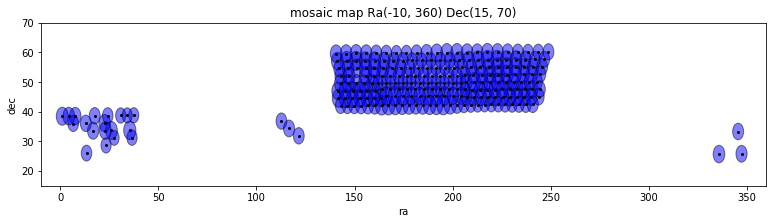

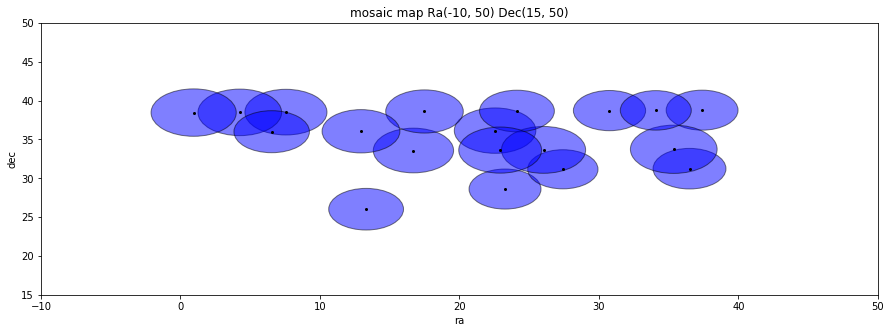

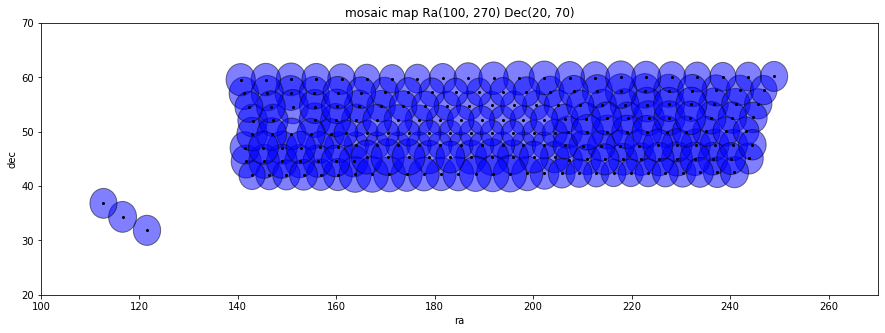

In [9]:
def map_mosaic(info, size=(15, 2), Ra=(-10, 360), Dec=(15, 70)):
    minRa, maxRa = Ra
    minDec, maxDec = Dec
    
    fig, ax = plt.subplots(figsize=size)
    for inf in info:
        ra = inf[1]
        dec = inf[2]
        if (ra >= minRa and ra <= maxRa) and (dec >= minDec and dec <= maxDec):
            ax.add_artist(plt.Circle((ra, dec), inf[0], edgecolor='black', alpha=0.5, facecolor='blue'))
            ax.plot(ra, dec, 'o', markersize=2, color='black')

    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('mosaic map Ra({}, {}) Dec({}, {})'.format(minRa, maxRa, minDec, maxDec))
    plt.xlim(minRa, maxRa)
    plt.ylim(minDec, maxDec)


map_mosaic(info, (13, 3))
map_mosaic(info, (15, 5), (-10, 50), (15, 50))
map_mosaic(info, (15, 5), (100, 270), (20, 70))

# Pair mosaics

In [10]:
load_overlaps = sc.parallelize(list(overlap_dict.items()), 32)
overlaps = load_overlaps.flatMap(lambda x : map(lambda y: tuple(sorted((x[0].split('_')[0], y.split('_')[0]))),
                                                x[1])).distinct()
overlaps.collect()

[('P145+57', 'P150+60'),
 ('P198+57', 'P200+55'),
 ('P223+55', 'P227+58'),
 ('P210+45', 'P213+47'),
 ('P221+45', 'P226+42'),
 ('P023+29', 'P027+31'),
 ('P11Hetdex12', 'P9Hetdex01'),
 ('P210+47', 'P214+45'),
 ('P241+55', 'P245+55'),
 ('P141+45', 'P141+47'),
 ('P155+52', 'P155+57'),
 ('P182+55', 'P187+55'),
 ('P219+50', 'P223+52'),
 ('P156+45', 'P160+47'),
 ('P233+48', 'P236+48'),
 ('P219+50', 'P219+52'),
 ('P156+45', 'P158+50'),
 ('P232+45', 'P236+48'),
 ('P227+50', 'P229+45'),
 ('P227+53', 'P232+55'),
 ('P170+42', 'P174+42'),
 ('P148+45', 'P153+42'),
 ('P239+50', 'P240+53'),
 ('P141+57', 'P145+60'),
 ('P14Hetdex04', 'P173+55'),
 ('P12Hetdex11', 'P14Hetdex04'),
 ('P243+50', 'P244+48'),
 ('P24Hetdex20', 'P26Hetdex03'),
 ('P222+58', 'P222+60'),
 ('P232+58', 'P236+55'),
 ('P232+55', 'P236+55'),
 ('P218+55', 'P219+50'),
 ('P11Hetdex12', 'P13Hetdex12'),
 ('P181+60', 'P184+57'),
 ('P240+53', 'P241+55'),
 ('P141+45', 'P142+42'),
 ('P148+45', 'P152+45'),
 ('P35Hetdex10', 'P37Hetdex15'),
 ('P241

# Prepare catalogue

In [11]:
header = ["label", "total_pixels", "x_pixels", "y_pixels",
          "integrated_intensity", "brightest_pixel", "brightest_pixel_x", "brightest_pixel_y",
          "brightest_pixel_RA", "brightest_pixel_DEC", "center_of_mass_x", "center_of_mass_y",
          "center_of_mass_RA", "center_of_mass_DEC", "center_of_gaus_fit_x", "center_of_gaus_fit_y",
          "center_of_gaus_fit_RA", "center_of_gaus_fit_DEC", "fit_x_axis", "fit_y_axis", "fit_theta",
          "deconv_x", "deconv_y", "integrated_intensity_fit", "ratio_residual"
         ]
catalogue = pd.read_csv(writeable + "catalogue_v5.csv", sep=",", names=header)

# Filter nans
rows = len(catalogue)
nan_rows = catalogue[catalogue.isnull().any(axis=1)]
ratio_nan = len(nan_rows) / rows
print('{0:.2f}% nan rows'.format(ratio_nan * 100))

# Show new catalogue
catalogue = catalogue[~catalogue.index.isin(nan_rows.index)].reindex()
catalogue['overlap'] = 0

# Add mosaic
catalogue['mosaic'], catalogue['object'] = catalogue['label'].str.split('_', 1).str
catalogue['object'] = catalogue['object'].astype(int)
catalogue.head()

0.15% nan rows


,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_x_axis,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,overlap,mosaic,object
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,1.719762,1.896624,-0.532125,0.632697,1.986707,0.971715,0.020838,0,P191+55,0
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,1.519698,1.080085,0.057949,0.000000,0.000000,0.330021,0.193748,0,P191+55,1
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,2.200380,1.810050,-0.030505,3.293620,1.472263,0.761026,0.051991,0,P191+55,2
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,1.720535,2.116901,0.055498,0.644249,2.974800,0.705155,0.082425,0,P191+55,3
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,3.113873,2.061817,-0.772092,6.145499,2.751915,1.080358,0.161090,0,P191+55,4


In [12]:
print(np.unique(catalogue['mosaic']))

['P000+38' 'P004+38' 'P006+36' 'P007+39' 'P012+36' 'P013+26' 'P016+34'
 'P017+39' 'P022+34' 'P022+36' 'P023+29' 'P024+39' 'P026+34' 'P027+31'
 'P030+39' 'P034+39' 'P035+34' 'P036+31' 'P037+39' 'P10Hetdex' 'P112+37'
 'P116+34' 'P11Hetdex12' 'P121+32' 'P12Hetdex11' 'P13Hetdex12' 'P140+60'
 'P141+45' 'P141+47' 'P141+57' 'P142+42' 'P142+50' 'P142+55' 'P143+52'
 'P145+45' 'P145+47' 'P145+57' 'P145+60' 'P146+42' 'P146+50' 'P146+55'
 'P147+52' 'P148+45' 'P149+42' 'P149+47' 'P14Hetdex04' 'P150+50' 'P150+57'
 'P150+60' 'P151+55' 'P152+45' 'P152+47' 'P153+42' 'P154+50' 'P155+52'
 'P155+55' 'P155+57' 'P155+60' 'P156+42' 'P156+45' 'P156+47' 'P158+50'
 'P159+45' 'P159+52' 'P15Hetdex13' 'P160+42' 'P160+47' 'P160+55' 'P160+57'
 'P161+60' 'P163+42' 'P163+45' 'P164+55' 'P165+57' 'P166+60' 'P167+42'
 'P169+55' 'P169+57' 'P16Hetdex13' 'P17' 'P170+42' 'P171+60' 'P173+55'
 'P174+42' 'P174+57' 'P176+60' 'P177+42' 'P178+55' 'P179+57' 'P181+42'
 'P181+60' 'P182+55' 'P184+42' 'P184+57' 'P186+60' 'P187+55' 'P18

# Finding overlapping sources

In [13]:
key = overlaps.take(237)[-1][0]
value = overlaps.take(237)[-1][1]
print(key, value)
catalogue[(catalogue["mosaic"] == key) | (catalogue["mosaic"] == value)].sort_values(by=["brightest_pixel_RA", "brightest_pixel_DEC"]).head()

P236+55 P237+58


,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_x_axis,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,overlap,mosaic,object
1614594,P236+55_5548,60,9,9,1.593870,0.001819,9498,4927,233.191551,55.099784,...,1.727464,2.019913,0.759600,0.739960,2.573830,1.608323,0.051215,0,P236+55,5548
1614651,P236+55_5605,59,12,8,0.943437,0.000697,9491,4965,233.195278,55.115742,...,2.732343,2.012721,-0.395823,5.039705,2.542394,0.971820,0.120883,0,P236+55,5605
1614736,P236+55_5690,44,7,7,0.818829,0.001001,9481,5022,233.200510,55.139669,...,2.019406,1.811879,-0.369352,2.571620,1.484684,0.822982,0.030637,0,P236+55,5690
1613989,P236+55_4943,35,8,11,0.376618,0.000365,9493,4522,233.209687,54.931342,...,8.000000,1.273585,5.494713,18.409002,0.000000,0.375214,0.266354,0,P236+55,4943
1614693,P236+55_5647,21,5,5,0.258572,0.000429,9469,4997,233.210149,55.129511,...,2.490426,1.395752,-0.708680,4.288640,0.000000,0.261334,0.080761,0,P236+55,5647


In [14]:
mosaic_dict = {k.split('_')[0]: i for i, k in enumerate(overlap_dict.keys()) }
mosaic_dict_rev = {i: k.split('_')[0] for i, k in enumerate(overlap_dict.keys()) }
mosaic_dict

{'P206+50': 0,
 'P150+60': 1,
 'P3Hetdex16': 2,
 'P160+42': 3,
 'P007+39': 4,
 'P146+42': 5,
 'P200+55': 6,
 'P237+43': 7,
 'P24Hetdex20': 8,
 'P222+58': 9,
 'P207+45': 10,
 'P149+47': 11,
 'P236+55': 12,
 'P40Hetdex19': 13,
 'P150+57': 14,
 'P227+58': 15,
 'P218+55': 16,
 'P210+45': 17,
 'P237+58': 18,
 'P116+34': 19,
 'P221+45': 20,
 'P202+42': 21,
 'P023+29': 22,
 'P11Hetdex12': 23,
 'P233+60': 24,
 'P23Hetdex20': 25,
 'P198+42': 26,
 'P181+60': 27,
 'P212+60': 28,
 'P21': 29,
 'P4Hetdex16': 30,
 'P197+60': 31,
 'P22Hetdex04': 32,
 'P151+55': 33,
 'P19Hetdex17': 34,
 'P210+47': 35,
 'P6': 36,
 'P169+55': 37,
 'P16Hetdex13': 38,
 'P241+55': 39,
 'P169+57': 40,
 'P141+45': 41,
 'P152+45': 42,
 'P35Hetdex10': 43,
 'P155+52': 44,
 'P187+55': 45,
 'P218+45': 46,
 'P037+39': 47,
 'P203+57': 48,
 'P215+50': 49,
 'P223+52': 50,
 'P245+55': 51,
 'P036+31': 52,
 'P160+47': 53,
 'P233+48': 54,
 'P228+60': 55,
 'P022+36': 56,
 'P179+57': 57,
 'P016+34': 58,
 'P219+52': 59,
 'P26Hetdex03': 60,
 

In [15]:
catalogue["mosaic_id"] = catalogue["mosaic"].apply(lambda x: mosaic_dict[x])
catalogue.loc[:, ["mosaic", "mosaic_id"]]

,mosaic,mosaic_id
0,P191+55,93
1,P191+55,93
2,P191+55,93
3,P191+55,93
4,P191+55,93
...,...,...
2291390,P198+57,207
2291391,P198+57,207
2291392,P198+57,207
2291393,P198+57,207


In [16]:
def detectOverlap(data, labels): 
    obj_rows = []
    eps = 0.0016 # Define distance between brightest pixel
    i = 0
    
    while i < len(data)-1:
        # Same mosaic
        if labels[i][0] == labels[i+1][0]:
            i += 1
            continue
        
        if sqrt(np.sum(np.power(data[i] - data[i+1], 2))) <= eps:
            # Add to new rows
            obj_rows.append(np.array(sorted([labels[i], labels[i+1]], key=lambda x: x[0])).astype(int))            
            # Only 2 sources can overlap
            i += 2
        else:
            i += 1
    
    return np.array(obj_rows)

In [17]:
select = lambda s, k, v: np.array_split(np.array(
    s[(s["mosaic"] == k) | (s["mosaic"] == v)]
    .sort_values(by=["brightest_pixel_RA", "brightest_pixel_DEC"])
    .loc[:, ["brightest_pixel_RA", "brightest_pixel_DEC", "mosaic_id", "object"]]
), 2, axis=1)


In [18]:
overlap_rows = overlaps.flatMap(lambda o: detectOverlap(np.around(select(catalogue, o[0], o[1])[0], 5), # o[0] + "_" + o[1],
                                          select(catalogue, o[0], o[1])[1].astype(int),
                                                       )
                               )

# Group overlapping sources

In [19]:
grouped_overlaps = overlap_rows.map(lambda x: (tuple(x[0]), x[1])).groupByKey().mapValues(list)

# Label overlapping sources

In [20]:
np_cat = catalogue.loc[:, ["mosaic_id", "object", "total_pixels"]].values
print(np_cat[:5])

[[93  0 43]
 [93  1 20]
 [93  2 45]
 [93  3 43]
 [93  4 74]]


In [21]:
np_cat[ np.where((np_cat[:, 0] == 36) & (np_cat[:, 1] == 4802)) ]

array([[  36, 4802,   21]])

In [22]:
# lookup = lambda d, arr: int(d[(d["mosaic_id"] == arr[0]) & (d["object"] == arr[1])]["total_pixels"].values)
lookup = lambda d, arr: d[np.where((np_cat[:, 0] == arr[0]) & (np_cat[:, 1] == arr[1] ))][0][-1]

def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item
            
            
def labelOverlap(combs, p_arg):
    overlap_arr = np.ones((len(combs), 3), dtype=int)
    overlap_arr[:, :2] = combs
    overlap_arr[p_arg, 2] += 1
    return overlap_arr

In [23]:
flattened_grouped_overlaps = grouped_overlaps.map(lambda g: tuple(zip(*[iter(tuple(flatten(g)))]*2)) )
# combinations = flattened_grouped_overlaps.collect()

In [24]:
source_pixels = flattened_grouped_overlaps.map(lambda combs: labelOverlap(combs,
                                                                          np.argmax([lookup(np_cat, c) for c in combs])
                                                                         )
                                              )
source_labels = source_pixels.collect()
source_labels[:5]

[array([[   41, 10725,     1],
        [  106,  2252,     2]]),
 array([[ 129, 7453,    2],
        [ 142, 4548,    1]]),
 array([[ 129, 2109,    2],
        [ 142,  705,    1]]),
 array([[  54, 2204,    2],
        [  71, 1626,    1],
        [ 158, 9749,    1],
        [ 108, 8034,    1]]),
 array([[  45, 8809,    2],
        [ 130, 8238,    1]])]

In [27]:
flatten_source_labels = np.array([item for sublist in source_labels for item in sublist])
print(flatten_source_labels.shape)
flatten_source_labels[:5]

(821216, 3)


array([[   41, 10725,     1],
       [  106,  2252,     2],
       [  129,  7453,     2],
       [  142,  4548,     1],
       [  129,  2109,     2]])

In [28]:
flatten_source_labels[(flatten_source_labels[:,0] == 148) & (flatten_source_labels[:,1] == 7047)]

array([[ 148, 7047,    1]])

In [29]:
df_source_labels = pd.DataFrame(flatten_source_labels, columns=["mosaic_id", "object", "overlap"])
df_source_labels.head()

,mosaic_id,object,overlap
0,41,10725,1
1,106,2252,2
2,129,7453,2
3,142,4548,1
4,129,2109,2


In [30]:
df_source_labels[(df_source_labels["mosaic_id"] == 148) & (df_source_labels["object"] == 7047)]

,mosaic_id,object,overlap
339649,148,7047,1


In [31]:
print(len(df_source_labels))

df_source_labels = df_source_labels.sort_values(['mosaic_id', 'object', 'overlap']).drop_duplicates(['mosaic_id', 'object'], keep='first')

print(len(df_source_labels))

df_source_labels[(df_source_labels["mosaic_id"] == 148) & (df_source_labels["object"] == 7047)]


821216
761634


,mosaic_id,object,overlap
339649,148,7047,1


In [32]:
# Remove duplicate pairs keep the lowest
df_source_labels.groupby(['mosaic_id', 'object'])['overlap'].min()

mosaic_id  object
0          5         1
           7         1
           8         1
           9         1
           10        1
                    ..
227        6880      1
           6881      1
           6882      1
           6884      1
           6887      1
Name: overlap, Length: 761634, dtype: int64

In [33]:
new_cat = pd.merge(catalogue, df_source_labels, how='left', on=['mosaic_id', 'object'])
new_cat.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,overlap_x,mosaic,object,mosaic_id,overlap_y
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,-0.532125,0.632697,1.986707,0.971715,0.020838,0,P191+55,0,93,1.0
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,0.057949,0.000000,0.000000,0.330021,0.193748,0,P191+55,1,93,NaN
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,-0.030505,3.293620,1.472263,0.761026,0.051991,0,P191+55,2,93,NaN
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,0.055498,0.644249,2.974800,0.705155,0.082425,0,P191+55,3,93,2.0
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,-0.772092,6.145499,2.751915,1.080358,0.161090,0,P191+55,4,93,NaN


In [34]:
new_cat['overlap'] = np.max(new_cat[['overlap_x', 'overlap_y']], axis=1).astype(int)
new_cat = new_cat.drop(labels=['overlap_x', 'overlap_y'], axis=1)
new_cat.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,1.896624,-0.532125,0.632697,1.986707,0.971715,0.020838,P191+55,0,93,1
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,1.080085,0.057949,0.000000,0.000000,0.330021,0.193748,P191+55,1,93,0
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,1.810050,-0.030505,3.293620,1.472263,0.761026,0.051991,P191+55,2,93,0
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,2.116901,0.055498,0.644249,2.974800,0.705155,0.082425,P191+55,3,93,2
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,2.061817,-0.772092,6.145499,2.751915,1.080358,0.161090,P191+55,4,93,0


In [35]:
new_cat[(new_cat["mosaic_id"] == 148) & (new_cat["object"] == 7047)]

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
1399735,P156+45_7047,21,4,6,0.317156,0.000468,4896,9033,156.154831,46.385457,...,2.384139,0.38035,0.0,3.939473,0.320109,0.075898,P156+45,7047,148,1


In [36]:
len(new_cat[new_cat["overlap"] > 0])

761634

In [37]:
len(new_cat[new_cat["overlap"] == 1])

397591

In [38]:
len(new_cat[new_cat["overlap"] == 2])

364043

In [39]:
len(new_cat[(new_cat["overlap"] == 0) | (new_cat["overlap"] == 2)])

1890288

# Save overlapping sources

In [51]:
out = "overlapping_pairs"
if os.path.isdir(out):
    shutil.rmtree(out)

flattened_grouped_overlaps.map(lambda g: g).coalesce(1, shuffle = True).saveAsTextFile(out)

In [52]:
os.replace("overlapping_pairs/part-00000", "overlap_pairs.csv")
shutil.rmtree(out)

In [54]:
cat_out = os.path.join(writeable, 'catalogue_v5.4.csv')
new_cat.to_csv(cat_out, sep=',')